# PDF Directory Text Analysis

This notebook processes multiple PDF files from a directory and performs NLP analysis to extract entities and relationships.

## Setup

First, let's install and import required packages:

In [ ]:
# Install required packages
# !pip install PyPDF2 spacy pandas
# !python -m spacy download en_core_web_sm

In [1]:
import os
import PyPDF2
import spacy
import pandas as pd
import networkx as nx
from collections import defaultdict
from pathlib import Path

## PDF Text Analyzer Class

Let's create our main analyzer class that will handle PDF processing and text analysis:

In [2]:
class PDFTextAnalyzer:
    def __init__(self):
        # Load English language model
        self.nlp = spacy.load("en_core_web_sm")
        
        # Entity types to track
        self.important_entities = {
            'ORG', 'PERSON', 'GPE', 'MONEY', 'DATE'
        }
        
        # Storage for extracted information
        self.entities = defaultdict(set)
        self.relationships = []
        self.document_metadata = []
    
    def read_pdf(self, pdf_path):
        """Extract text from a single PDF file"""
        try:
            with open(pdf_path, 'rb') as file:
                # Create PDF reader object
                pdf_reader = PyPDF2.PdfReader(file)
                
                # Extract text from all pages
                text = ""
                for page in pdf_reader.pages:
                    text += page.extract_text() + "\n"
                
                return text.strip()
        except Exception as e:
            print(f"Error reading PDF {pdf_path}: {str(e)}")
            return ""

    def process_directory(self, directory_path):
        """Process all PDFs in a directory"""
        dir_path = Path(directory_path)
        
        # Process each PDF file
        for pdf_path in dir_path.glob("*.pdf"):
            try:
                # Read PDF content
                text = self.read_pdf(pdf_path)
                if text:
                    # Process the text
                    self.extract_entities_and_relationships(text, source=pdf_path.name)
                    print(f"Successfully processed: {pdf_path.name}")
            except Exception as e:
                print(f"Error processing {pdf_path.name}: {str(e)}")
    
    def extract_entities_and_relationships(self, text, source=None):
        """Extract entities and their relationships from text"""
        doc = self.nlp(text)
        
        # Extract entities
        doc_entities = []
        for ent in doc.ents:
            if ent.label_ in self.important_entities:
                self.entities[ent.label_].add((ent.text, source))
                doc_entities.append((ent.text, ent.label_))
        
        # Extract relationships from each sentence
        for sent in doc.sents:
            sent_doc = self.nlp(sent.text)
            entities_in_sent = [(e.text, e.label_) for e in sent_doc.ents 
                              if e.label_ in self.important_entities]
            
            if len(entities_in_sent) >= 2:
                for i in range(len(entities_in_sent)-1):
                    self.relationships.append({
                        'source': entities_in_sent[i][0],
                        'target': entities_in_sent[i+1][0],
                        'sentence': sent.text,
                        'document': source
                    })
        
        # Store document metadata
        if source:
            self.document_metadata.append({
                'source': source,
                'entity_count': len(doc_entities),
                'relationship_count': len(self.relationships)
            })

## Analysis and Results Methods

Now let's add methods to get summaries and save results:

In [3]:
# Add these methods to the PDFTextAnalyzer class
def get_entity_summary(self):
    """Get summary of extracted entities"""
    summary = []
    for entity_type, entities in self.entities.items():
        for entity, source in entities:
            summary.append({
                'type': entity_type,
                'entity': entity,
                'source': source
            })
    return pd.DataFrame(summary)

def get_relationship_summary(self):
    """Get summary of extracted relationships"""
    return pd.DataFrame(self.relationships)

def get_document_summary(self):
    """Get summary of processed documents"""
    return pd.DataFrame(self.document_metadata)

def save_results(self, output_dir):
    """Save analysis results to CSV files"""
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save all summaries to CSV files
    self.get_entity_summary().to_csv(output_path / 'entities.csv', index=False)
    self.get_relationship_summary().to_csv(output_path / 'relationships.csv', index=False)
    self.get_document_summary().to_csv(output_path / 'document_metadata.csv', index=False)

# Add these methods to the PDFTextAnalyzer class
PDFTextAnalyzer.get_entity_summary = get_entity_summary
PDFTextAnalyzer.get_relationship_summary = get_relationship_summary
PDFTextAnalyzer.get_document_summary = get_document_summary
PDFTextAnalyzer.save_results = save_results

## Using the Analyzer

Now let's use our analyzer on a directory of PDFs:

In [4]:
# Initialize the analyzer
analyzer = PDFTextAnalyzer()

# Set your PDF directory path
pdf_directory = "pdfs"

# Process all PDFs in the directory
analyzer.process_directory(pdf_directory)

Successfully processed: 49.pdf
Successfully processed: 60.pdf
Successfully processed: 89.pdf
Successfully processed: 63.pdf
Successfully processed: 73.pdf
Successfully processed: 9.pdf
Successfully processed: 8.pdf
Successfully processed: 16.pdf
Successfully processed: 114.pdf
Successfully processed: 15.pdf
Successfully processed: 14.pdf
Successfully processed: 111.pdf
Successfully processed: 105.pdf
Successfully processed: 10.pdf
Successfully processed: 38.pdf
Successfully processed: 39.pdf
Successfully processed: 11.pdf
Successfully processed: 110.pdf
Successfully processed: 106.pdf
Successfully processed: 112.pdf
Successfully processed: 13.pdf
Successfully processed: 113.pdf
Successfully processed: 107.pdf
Successfully processed: 36.pdf
Successfully processed: 21.pdf
Successfully processed: 35.pdf
Successfully processed: 108.pdf
Successfully processed: 31.pdf
Successfully processed: 24.pdf
Successfully processed: 26.pdf
Successfully processed: 27.pdf
Successfully processed: 69.pdf
S

## Viewing Results

Let's examine what we found:

In [5]:
# Display basic statistics
print("Analysis Results:")
print(f"Total documents processed: {len(analyzer.document_metadata)}")

print("\nEntities Found:")
display(analyzer.get_entity_summary())

print("\nRelationships Found:")
display(analyzer.get_relationship_summary())

Analysis Results:
Total documents processed: 44

Entities Found:


,type,entity,source
0,ORG,VIII,63.pdf
1,ORG,Insured,36.pdf
2,ORG,UNO N Personnel,69.pdf
3,ORG,Authority,2.pdf
4,ORG,United Nations,11.pdf
...,...,...,...
2491,PERSON,KInKtheKletter,15.pdf
2492,PERSON,hasgivennoticethatitintendstostriveforalong-te...,113.pdf
2493,PERSON,Ko,11.pdf
2494,PERSON,approva l,47.pdf



Relationships Found:


,source,target,sentence,document
0,UNITED NATIONS,Kosovo,UNITED NATIONS \nUnited Nations Interim \nAdm...,49.pdf
1,Kosovo,Kosovo,UNITED NATIONS \nUnited Nations Interim \nAdm...,49.pdf
2,Kosovo,Investigation Task Force \n \nAllegation of Po...,UNITED NATIONS \nUnited Nations Interim \nAdm...,49.pdf
3,29 April 2004,Divisional,"On 29 April 2004 a Divisional Manager, UNMIK P...",49.pdf
4,Divisional,UNMIK Pil lar IV,"On 29 April 2004 a Divisional Manager, UNMIK P...",49.pdf
...,...,...,...,...
2264,2 Representative,FIDS,Conclusions \n \nFact is that Vendor 2 Repres...,44.pdf
2265,FIDS,FIDS,Conclusions \n \nFact is that Vendor 2 Repres...,44.pdf
2266,Vendor 2,FIDS,It has to be assumed that Vendor 2 won the FID...,44.pdf
2267,FIDS,Vendor 2 \nRepresentative,Although PEAP Official as the responsible offi...,44.pdf


## Save Results

Finally, let's save our results to CSV files:

In [6]:
# Save results to CSV files
analyzer.save_results("analysis_results")
print("Results saved to 'analysis_results' directory")

Results saved to 'analysis_results' directory


## Data Cleaning

In [7]:
import pandas as pd
import re

# ------------------------------------------------------------------
# 1. Load Your CSV Data
# ------------------------------------------------------------------
entities_df = pd.read_csv("analysis_results/entities.csv")
relationships_df = pd.read_csv("analysis_results/relationships.csv")
document_metadata_df = pd.read_csv("analysis_results/document_metadata.csv")


In [8]:

# ------------------------------------------------------------------
# 2. Define a Function to Normalize Entity Text
# ------------------------------------------------------------------
def normalize_entity_text(text):
    """ 
    Example text normalization steps:
      - Lowercase
      - Strip leading/trailing whitespace
      - Remove extra internal whitespace
      - Remove punctuation
    """
    if not isinstance(text, str):
        return text  # If it's not a string (e.g. NaN), just return as-is
    
    # Lowercase
    text = text.lower().strip()
    # Remove punctuation (except maybe certain chars if needed)
    text = re.sub(r"[^\w\s\-]", "", text)
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    # Trim again after
    text = text.strip()
    
    return text

# ------------------------------------------------------------------
# 3. Optionally, Define Synonyms or Known Canonical Forms
# ------------------------------------------------------------------
# For instance, if "united nations" and "u.n." and "un" should
# all be the same entity, you can unify them in a dictionary.

synonym_map = {
    "united nations": "un",
    "u.n": "un",
    "u.n.": "un",
    "kosovo": "republic of kosovo",  # example
    # add more synonyms or expansions here
}

def apply_synonyms(normalized_text):
    """Look up normalized text in a synonym map to unify references."""
    # If the normalized text is in the map, return the mapped value.
    # Otherwise, return the original.
    return synonym_map.get(normalized_text, normalized_text)


In [9]:

# ------------------------------------------------------------------
# 4. Clean and Validate "entities_df"
# ------------------------------------------------------------------
# 4a. Normalize the entity column
entities_df["cleaned_entity"] = entities_df["entity"].apply(normalize_entity_text)

# 4b. Apply synonyms
entities_df["cleaned_entity"] = entities_df["cleaned_entity"].apply(apply_synonyms)

# 4c. De-duplicate
#    Usually, you'd want to ensure each (type, cleaned_entity, source) is unique.
entities_df.drop_duplicates(subset=["type", "cleaned_entity", "source"], inplace=True)

# 4d. (Optional) Filter out obviously incorrect entities
#     For example, if "cleaned_entity" is too short (e.g. length < 2)
#     or purely numeric, it may be noise
entities_df = entities_df[
    (entities_df["cleaned_entity"].str.len() > 2) &
    (entities_df["cleaned_entity"].str.isnumeric() == False)
].copy()

In [10]:

# ------------------------------------------------------------------
# 5. Clean and Validate "relationships_df"
# ------------------------------------------------------------------
# Typically you will want to normalize the 'source' and 'target' columns
# just like we did for entities, so the relationship references line up
# with your cleaned entity names.

relationships_df["cleaned_source"] = relationships_df["source"].apply(normalize_entity_text).apply(apply_synonyms)
relationships_df["cleaned_target"] = relationships_df["target"].apply(normalize_entity_text).apply(apply_synonyms)

# De-duplicate relationships
# You can define the subset as you see fit. Often (cleaned_source, cleaned_target, document)
# is enough, or you might want to keep the 'sentence' if it’s significantly different.
relationships_df.drop_duplicates(subset=["cleaned_source", "cleaned_target", "document"], inplace=True)

# (Optional) Filter out relationships if source == target or if the text is obviously noise
relationships_df = relationships_df[
    (relationships_df["cleaned_source"] != relationships_df["cleaned_target"]) &
    (relationships_df["cleaned_source"].str.len() > 2) &
    (relationships_df["cleaned_target"].str.len() > 2)
].copy()

In [11]:
# ------------------------------------------------------------------
# 6. (Optional) Validate Document Metadata
# ------------------------------------------------------------------
# You could, for instance, confirm that each PDF "source" in the metadata
# is also found in your entities or relationships, etc.
# For now, we just make sure no duplicates or missing sources.

document_metadata_df.drop_duplicates(subset=["source"], inplace=True)
document_metadata_df = document_metadata_df.dropna(subset=["source"])

In [12]:
# ------------------------------------------------------------------
# 7. Save Cleaned Data (or keep in memory for analysis)
# ------------------------------------------------------------------
entities_df.to_csv("analysis_results/entities_cleaned.csv", index=False)
relationships_df.to_csv("analysis_results/relationships_cleaned.csv", index=False)
document_metadata_df.to_csv("analysis_results/document_metadata_cleaned.csv", index=False)

print("Data cleaning and validation complete.")

Data cleaning and validation complete.


## GRAPH

In [14]:
conda install matplotlib

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/homebrew/Caskroom/miniconda/base/envs/myenv

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    contourpy-1.3.1            |  py312h48ca7d4_0         264 KB
    cycler-0.11.0              |     pyhd3eb1b0_0          12 KB
    fonttools-4.55.3           |  py312h80987f9_0         2.9 MB
    freetype-2.12.1            |       h1192e45_0         570 KB
    kiwisolver-1.4.8           |  py312h313beb8_0          67 KB
    lcms2-2.16                 |       he93ba84_0         238 KB
    lerc-4.0.0                 |       h313beb8_0         196 KB
    libdeflate-1.22            |       h80987f9_0          57 KB
    libtiff-4.5.1              |       hc9ead59_1         494 KB
    libwebp-base-1.3.2         |       h80987f9_1

In [15]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [13]:
# Load the CSV files
entities_df = pd.read_csv("analysis_results/entities_cleaned.csv")  # Load cleaned entity data
relationships_df = pd.read_csv("analysis_results/relationships_cleaned.csv")
document_metadata_df = pd.read_csv("analysis_results/document_metadata_cleaned.csv")

In [22]:
# Create a directed graph (if relationships have directionality)
G = nx.DiGraph()

# Add nodes (Entities)
for _, row in entities_df.iterrows():
    # entity_name = row["cleaned_entity"]
    # entity_type = row["type"]
    # source_doc = row["source"]  # The document where this entity was found
    entity_name = row.get("type", "UNKNOWN")
    entity_type = row.get("type", "UNKNOWN")  # Use .get() to avoid KeyError
    source_doc = row.get("source", "UNKNOWN")

    # Add node with attributes (type and source document)
    G.add_node(entity_name, entity_type=entity_type, source=source_doc)

# Add edges (Relationships)
for _, row in relationships_df.iterrows():
    source_entity = row["cleaned_source"]
    target_entity = row["cleaned_target"]
    relationship_text = row["sentence"]  # The sentence describing the relationship
    document = row["document"]  # The document where this relationship was found

    # Add edge with attributes (sentence and document)
    G.add_edge(source_entity, target_entity, sentence=relationship_text, document=document)

In [23]:
conda install scipy

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64

Note: you may need to restart the kernel to use updated packages.


In [21]:
entities_df = pd.read_csv("analysis_results/entities_cleaned.csv")

print("Columns in entities_cleaned.csv:", entities_df.columns)

Columns in entities_cleaned.csv: Index(['type', 'entity', 'source', 'cleaned_entity'], dtype='object')


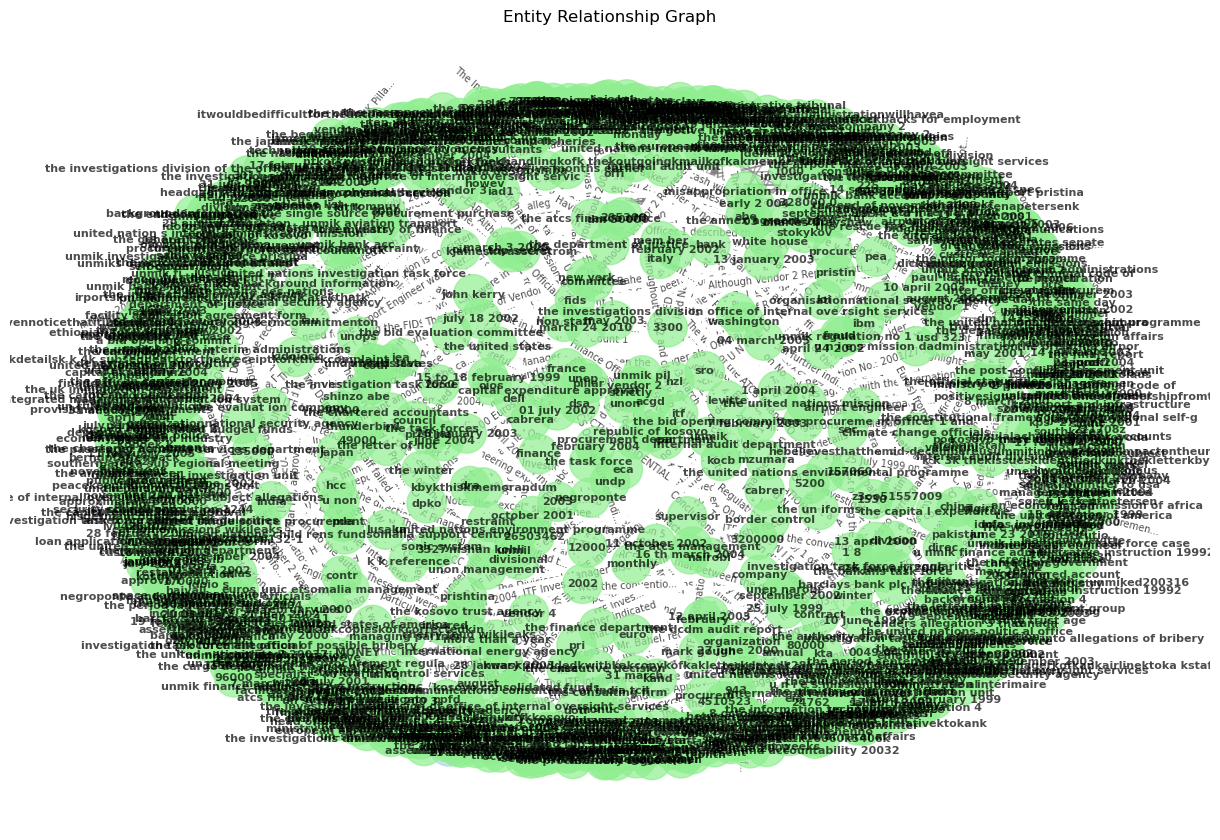

In [24]:
# ----------------------------------------------------------------
# Step 3: Visualizing the Graph
# ----------------------------------------------------------------

# Set figure size
plt.figure(figsize=(12, 8))

# Define position layout
pos = nx.spring_layout(G, k=0.5)

# Draw nodes (Different colors for different entity types)
node_colors = [
    "lightblue" if G.nodes[n].get("entity_type", "UNKNOWN") == "ORG" else "lightgreen"
    for n in G.nodes
]
nx.draw(
    G, pos, node_color=node_colors, with_labels=True, edge_color="gray",
    node_size=800, font_size=8, font_weight="bold", alpha=0.7
)

# Draw edge labels (shortened relationship text)
edge_labels = { (u, v): G[u][v]["sentence"][:30] + "..." for u, v in G.edges }
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, alpha=0.7)

plt.title("Entity Relationship Graph")
plt.show()

In [ ]:
# 1️⃣ Find the Most Connected Entities
degree_centrality = nx.degree_centrality(G)
top_connected_entities = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("🔝 Top 10 Most Connected Entities:")
for entity, centrality in top_connected_entities:
    print(f"{entity}: {centrality:.4f}")

In [ ]:
# 2️⃣ Find Strongest Relationships (Most Commonly Connected Pairs)
edge_weights = { (u, v): len(G[u][v]["sentence"]) for u, v in G.edges }
top_relationships = sorted(edge_weights.items(), key=lambda x: x[1], reverse=True)[:10]

print("🔗 Top 10 Strongest Relationships:")
for (source, target), weight in top_relationships:
    print(f"{source} → {target} (Length of Relationship Sentence: {weight})")


In [ ]:
# 3️⃣ Find Clusters of Related Entities (Communities)
from networkx.algorithms import community

communities = community.greedy_modularity_communities(G)
print(f"🔍 Detected {len(communities)} Communities:")
for i, comm in enumerate(communities[:5]):  # Display first 5 communities
    print(f"Community {i+1}: {list(comm)[:10]} ...")  # Show only first 10 members

## PERHAPS A CLEANER GRAPH

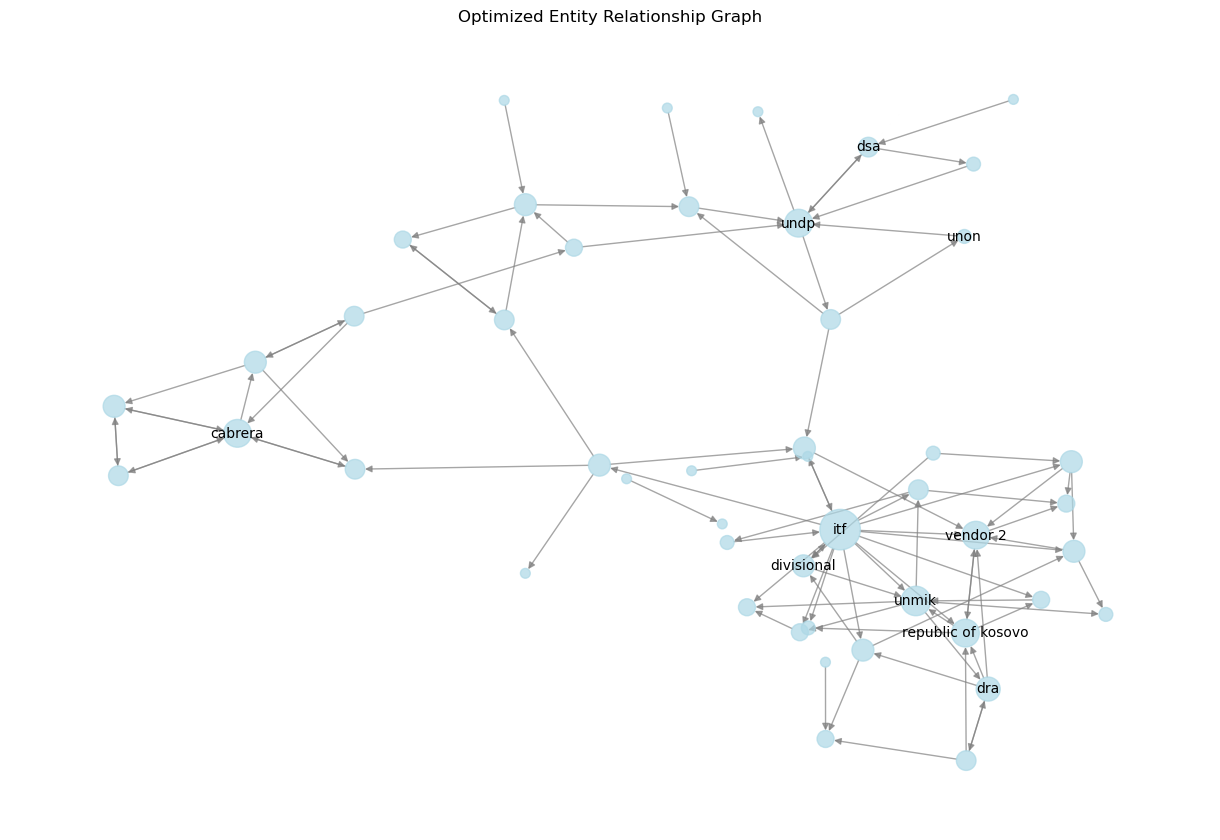

In [25]:
# Load the CSV files
entities_df = pd.read_csv("analysis_results/entities_cleaned.csv")
relationships_df = pd.read_csv("analysis_results/relationships_cleaned.csv")

# Create a directed graph
G = nx.DiGraph()

# Add nodes with attributes
for _, row in entities_df.iterrows():
    entity_name = row["cleaned_entity"]
    entity_type = row.get("type", "UNKNOWN")
    G.add_node(entity_name, entity_type=entity_type)

# Add edges
for _, row in relationships_df.iterrows():
    source = row["cleaned_source"]
    target = row["cleaned_target"]
    G.add_edge(source, target, document=row["document"])

# Step 1: Filter top 50 most connected entities
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
top_node_names = [n[0] for n in top_nodes]

# Create a subgraph
G_sub = G.subgraph(top_node_names)

# Step 2: Use Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G_sub)

# Step 3: Scale node sizes based on degree
node_sizes = [G_sub.degree[n] * 50 for n in G_sub.nodes]

# Step 4: Only label the top 10 most connected nodes
top_labels = {node: node for node, _ in top_nodes[:10]}

# Step 5: Draw graph
plt.figure(figsize=(12, 8))
nx.draw(
    G_sub, pos, node_size=node_sizes, node_color="lightblue",
    edge_color="gray", alpha=0.7, with_labels=False  # Hide most labels
)
nx.draw_networkx_labels(G_sub, pos, labels=top_labels, font_size=10)  # Show only top labels

plt.title("Optimized Entity Relationship Graph")
plt.show()